In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
import time

from sklearn.datasets import make_regression
from utils.utils import make_writer

os.environ["TF_KERAS"]='1'
%matplotlib inline

# Most common bugs II

## Switching between train/test modes when using batch norm or dropout

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [6]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10)
            

    def call(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model
model = MyModel()

In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [8]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss_correct = tf.keras.metrics.Mean(name='test_loss')
test_accuracy_correct = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

test_loss_wrong = tf.keras.metrics.Mean(name='test_loss')
test_accuracy_wrong = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [9]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [10]:
@tf.function
def test_step_correct(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss_correct(t_loss)
    test_accuracy_correct(labels, predictions)

In [11]:
@tf.function
def test_step_wrong(images, labels):
    predictions = model(images, training=True)
    t_loss = loss_object(labels, predictions)

    test_loss_wrong(t_loss)
    test_accuracy_wrong(labels, predictions)

In [88]:
EPOCHS = 5
writer_wrong = make_writer(os.path.join('summaries'), 'training_mode_bug/wrong_modes')
writer_correct = make_writer(os.path.join('summaries'), 'training_mode_bug/correct_modes')


start = time.time()
for epoch in range(EPOCHS):

    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss_wrong.reset_states()
    test_accuracy_wrong.reset_states()
    test_loss_correct.reset_states()
    test_accuracy_correct.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    
    for test_images, test_labels in test_ds:
        test_step_wrong(test_images, test_labels)
        test_step_correct(test_images, test_labels)
    
    with writer_wrong.as_default():
        tf.summary.scalar('Test Loss', test_loss_wrong.result(), step=epoch)
        tf.summary.scalar('Test Accuracy', test_accuracy_wrong.result() * 100, step=epoch)
    
    with writer_correct.as_default():
        tf.summary.scalar('Test Loss', test_loss_correct.result(), step=epoch)
        tf.summary.scalar('Test Accuracy', test_accuracy_correct.result() * 100, step=epoch)

    message = (f'Epoch: {epoch + 1}, Test Loss Wrong: {test_loss_wrong.result()},'
               f'Test Loss Correct: {test_loss_correct.result()},' 
               f'Test Accuracy Wrong: {test_accuracy_wrong.result() * 100},'
               f'Test Accuracy Correct: {test_accuracy_correct.result() * 100}'
               
              )
    print(message)   

print(f'Time elapsed {time.time() - start}')

Creating a tensorboard directory: summaries/training_mode_bug/wrong_modes
Creating a tensorboard directory: summaries/training_mode_bug/correct_modes
Epoch: 1, Test Loss Wrong: 0.058047182857990265,Test Loss Correct: 0.045169468969106674,Test Accuracy Wrong: 98.15999603271484,Test Accuracy Correct: 98.54999542236328
Epoch: 2, Test Loss Wrong: 0.05414677411317825,Test Loss Correct: 0.04364173114299774,Test Accuracy Wrong: 98.22999572753906,Test Accuracy Correct: 98.54000091552734
Epoch: 3, Test Loss Wrong: 0.07029888033866882,Test Loss Correct: 0.05454886704683304,Test Accuracy Wrong: 97.87999725341797,Test Accuracy Correct: 98.31999969482422
Epoch: 4, Test Loss Wrong: 0.06806743144989014,Test Loss Correct: 0.05442759022116661,Test Accuracy Wrong: 98.12999725341797,Test Accuracy Correct: 98.43999481201172
Epoch: 5, Test Loss Wrong: 0.07623559236526489,Test Loss Correct: 0.05882542207837105,Test Accuracy Wrong: 98.06999969482422,Test Accuracy Correct: 98.47999572753906
Time elapsed 143.4

## Numerical instabilities

### Exploding and vanishing gradients

### A bit of theory:

- $X$ - input
- $o$ - output
- $L$ - number of layers in the network
- $l$ - layer $l$ with the transormation $f_l$ and corresponding weights $W^l$ and the hidden variable $h^l$

 $$h^l = f_l(h^{l-1})$$ $$o = f_L \circ ... \circ f_1(X)$$
 
If all $h_l$ and the input are vectors, one can write the gradient of $o$ with respect to any set of parameters $W^l$ as:

$$\partial_{W^l}o = \partial_{h^{L-1}}{h^L} ... \partial_{h^{l}}h^{l+1} \partial_{W^{l}}h^l   $$

#### Vanishing gradients:

- Historically sigmoid was used as an activation function
- It resembles a thresholding function and was appealing, since neural nets were inspired by biological neural networks, where biological neurons either fire fully or not at all

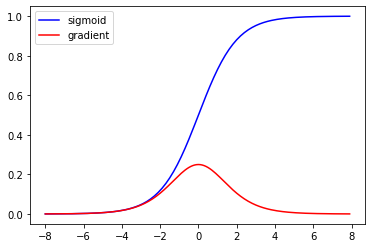

In [2]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1))

with tf.GradientTape() as tape:
    y = tf.nn.sigmoid(x)

grad = tape.gradient(y, x).numpy()
x = x.numpy()
y = y.numpy()
    
plt.plot(x, y, 'b', label='sigmoid')
plt.plot(x, grad, 'r', label='gradient') 
plt.legend()
plt.show()

- Gradients vanish for both big and small inputs
- Multiply many layers and if the inputs are not near zero, then a gradient can vanish
- Gradient cut off at some layer --> difficult to build deep nets

### Tiny exercise:

- What's the usual solution for this specific instance of the problem?
- Make a similar plot for the solution

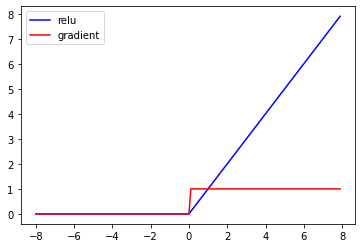

In [11]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1))

with tf.GradientTape() as tape:
    y = tf.nn.relu(x)

grad = tape.gradient(y, x).numpy()
x = x.numpy()
y = y.numpy()
    
plt.plot(x, y, 'b', label='relu')
plt.plot(x, grad, 'r', label='gradient') 
plt.legend()
plt.show()

#### Vanishing gradients in RNNs



- See-rnn package helps debug and analyze RNNs. 
- Vanishing gradient example below

In [91]:
from tensorflow.keras.layers import Input, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from see_rnn import get_gradients, features_1D, features_2D

def make_model(rnn_layer, batch_shape, units):
    ipt = Input(batch_shape=batch_shape)
    x   = rnn_layer(units, activation='tanh', return_sequences=True)(ipt)
    out = rnn_layer(units, activation='tanh', return_sequences=False)(x)
    model = Model(ipt, out)
    model.compile(Adam(4e-3), 'mse')
    return model
    
def make_data(batch_shape):
    return np.random.randn(*batch_shape), \
           np.random.uniform(-1, 1, (batch_shape[0], units))

def train_model(model, iterations, batch_shape):
    x, y = make_data(batch_shape)
    for i in range(iterations):
        model.train_on_batch(x, y)
        print(end='.')  # progbar
        if i % 40 == 0:
            x, y = make_data(batch_shape)

units = 32
batch_shape = (32, 100, 2*units)

model_rnn = make_model(SimpleRNN, batch_shape, units)
model_lstm = make_model(LSTM, batch_shape, units)
train_model(model_rnn, 300, batch_shape)
train_model(model_lstm, 300, batch_shape)

x, y  = make_data(batch_shape)
grads_all_rnn  = get_gradients(model_rnn, 1, x, y)
grads_all_lstm  = get_gradients(model_lstm, 1, x, y) 

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

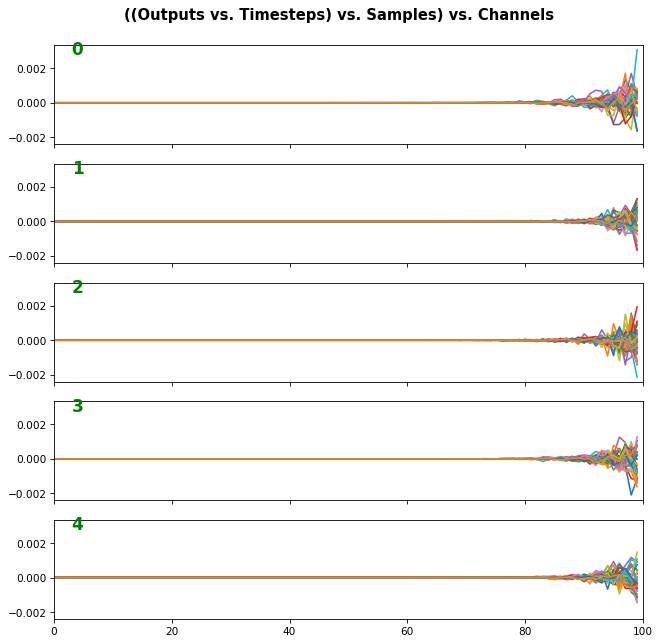

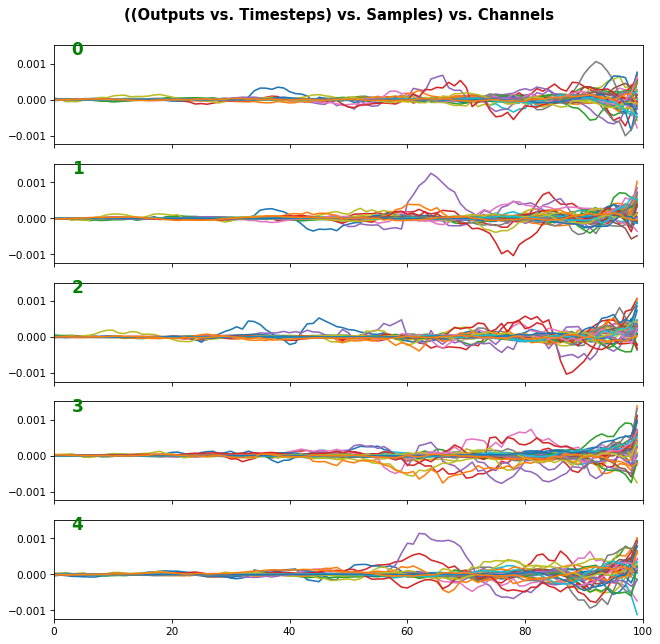

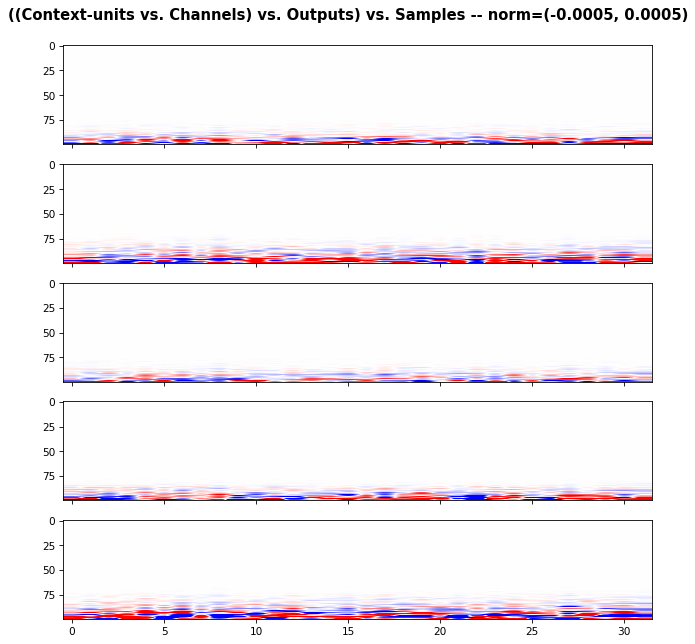

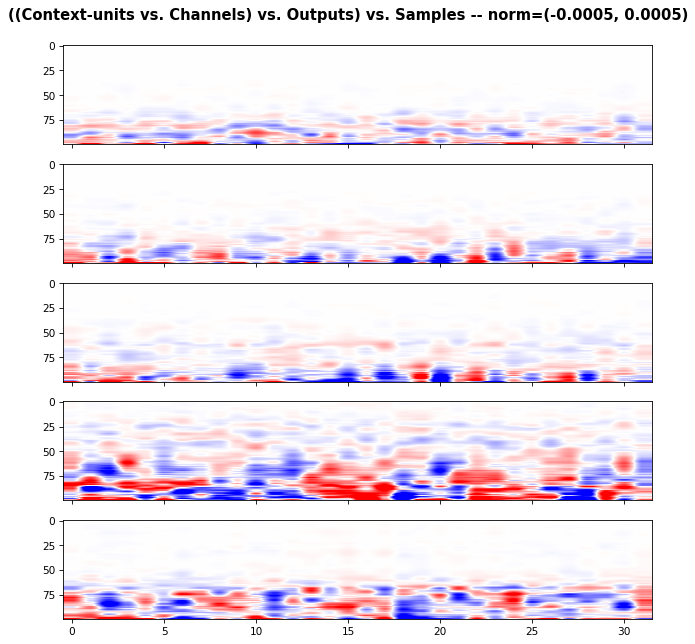

In [102]:
# Plot RNN VS LSTM 1D
features_1D(grads_all_rnn[:, :, :5], n_rows=5, show_xy_ticks=[1,1])
features_1D(grads_all_lstm[:, :, :5], n_rows=5, show_xy_ticks=[1,1])

# Plot RNN VS LSTM 2D
features_2D(grads_all_rnn[:5, :, :], n_rows=5, show_xy_ticks=[1,1], norm=(-.0005, .0005))
features_2D(grads_all_lstm[:5, :, :], n_rows=5, show_xy_ticks=[1,1], norm=(-.0005, .0005))
plt.show()

#### Exploding gradients and gradient clipping



In [144]:
M = tf.random.normal((4, 4))
print('a single matrix \n', M)
for i in range(100):
    M = tf.matmul(M, tf.random.normal((4, 4)))

print('after multiplying 100 matrices\n', M.numpy())

a single matrix 
 tf.Tensor(
[[-0.1849229   0.32942605  0.08593092 -0.24966481]
 [-1.6074395  -0.9082498   1.5625314   0.30956605]
 [-0.0680668  -0.29461113  1.2397891   1.5580487 ]
 [ 0.76984364  1.4797311  -0.61358035  0.09033407]], shape=(4, 4), dtype=float32)
after multiplying 100 matrices
 [[ 3.6280650e+26 -4.5571419e+26 -8.9787166e+26  1.6084891e+26]
 [-1.3452225e+27  1.6897079e+27  3.3291497e+27 -5.9639925e+26]
 [ 3.6236123e+27 -4.5515490e+27 -8.9676978e+27  1.6065148e+27]
 [ 3.9152509e+27 -4.9178707e+27 -9.6894425e+27  1.7358119e+27]]


#### Gradient clipping

- Clip a gradient by norm:
    - $ \textbf{g} \gets min\left(1, \frac{\theta}{||\textbf{g}||}\textbf{g} \right)$
    - For example: $$\textbf{g}= [-2, 3, 6]$$ $$\theta = 5$$ $$||\textbf{g}|| = 7$$ $$\textbf{g} \gets [-2, 3, 6]\cdot \frac{5}{7}$$
- Clip gradient by value:
    - if $g_i < \theta_1$, then $g_i \gets \theta_1$ and $g_i > \theta_2$, then $g_i \gets \theta_2$
    -  For example: $$\textbf{g}= [-2, 3, 10]$$ $$\theta_1 = 0, \theta_2 = 5$$  $$ \textbf{g} \gets [0, 3, 5]$$

In [14]:
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :].astype('float32'), X[n_train:, :].astype('float32')
trainy, testy = y[:n_train].astype('float32'), y[n_train:].astype('float32')

# Creat tf.Datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainy)).shuffle(trainX.shape[0]).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((testX, testy)).shuffle(testX.shape[0]).batch(32)

In [64]:
class RegressorNet(tf.keras.Model):
    def __init__(self, input_shape, optimizer):
        super(RegressorNet, self).__init__()
        
        self.loss_object = tf.keras.losses.MeanSquaredError()
        self.optimizer = optimizer
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Input(input_shape),
            tf.keras.layers.Dense(25, activation='relu', kernel_initializer='he_uniform', name='dense_1'),
            tf.keras.layers.Dense(1, activation='linear', name='out')
        ])
    
    def summary(self):
        self.regressor.summary()
    
    def call(self, X):
        return self.regressor(X)
    
    def get_loss(self, X, y_true):
        y_pred = self(X)
        l2_loss = self.loss_object(y_true, y_pred)
        return l2_loss
    
    def grad_step(self, X, y_true):
        with tf.GradientTape() as tape:
            loss = self.get_loss(X, y_true)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss, gradients

In [65]:
# Specify an optimizer and an instance of the model
optimizer = tf.keras.optimizers.SGD(0.01, 0.9)
model_non_clipped = RegressorNet(input_shape=trainX.shape[1], optimizer=optimizer)
# Show summary
model_non_clipped.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                525       
_________________________________________________________________
out (Dense)                  (None, 1)                 26        
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Create loss objects for calculation of the mean loss across batches
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [20]:
def train(model, epochs, train_dataset, test_dataset, save_dir):
    
    writer = make_writer(os.path.join('summaries'), save_dir)
    
    for epoch in range(0, epochs + 1):
        
        train_loss.reset_states()
        test_loss.reset_states()

    
        if epoch % 10 == 0:
            print('Epoch {} is running...'.format(epoch))
        
        for X, y in train_dataset:
            # Gradient update step
            loss_train, gradients = model.grad_step(X, y)
            train_loss(loss_train)
            
        for X, y in test_dataset:
            # Gradient update step
            loss_test = model.get_loss(X, y)
            test_loss(loss_test)
        
        if epoch % 10 == 0:
            print(f'Train loss: {train_loss.result()}')

        # Tensorboard
        with writer.as_default():
            tf.summary.scalar('Test loss', test_loss.result(), step=epoch)
            tf.summary.scalar('Train loss', train_loss.result(), step=epoch)
            for layer_number in range(len(gradients)):
                if layer_number % 2 == 0:
                    tf.summary.histogram(f'{model.layers[0].layers[layer_number // 2].name}/kernel_0', \
                                         gradients[layer_number], step=epoch, buckets=1)
                else:
                    tf.summary.histogram(f'{model.layers[0].layers[(layer_number - 1) // 2].name}/bias_0', \
                                         gradients[layer_number], step=epoch, buckets=1)

In [68]:
train(model_non_clipped, 100, train_dataset, test_dataset, 'exploding_grads/no_clipping/')

Creating a tensorboard directory: summaries/exploding_grads/no_clipping/
Epoch 0 is running...
Train loss: nan
Epoch 10 is running...
Train loss: nan
Epoch 20 is running...
Train loss: nan
Epoch 30 is running...
Train loss: nan
Epoch 40 is running...
Train loss: nan
Epoch 50 is running...
Train loss: nan
Epoch 60 is running...
Train loss: nan
Epoch 70 is running...
Train loss: nan
Epoch 80 is running...
Train loss: nan
Epoch 90 is running...
Train loss: nan
Epoch 100 is running...
Train loss: nan


### Exercise

- implement gradient clipping by norm OR by value in a new class RegressorNetClipped
- plot gradient updates with clipping

Hint: check tf.clip_by_value and tf.clip_by_global_norm

In [17]:
class RegressorNetClipped(tf.keras.Model):
    def __init__(self, input_shape, optimizer):
        super(RegressorNetClipped, self).__init__()
        
        self.loss_object = tf.keras.losses.MeanSquaredError()
        self.optimizer = optimizer
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Input(input_shape),
            tf.keras.layers.Dense(25, activation='relu', kernel_initializer='he_uniform', name='dense_1'),
            tf.keras.layers.Dense(1, activation='linear', name='out')
        ])
    
    def summary(self):
        self.regressor.summary()
    
    def call(self, X):
        return self.regressor(X)
    
    def get_loss(self, X, y_true):
        y_pred = self(X)
        l2_loss = self.loss_object(y_true, y_pred)
        return l2_loss
    
    def grad_step(self, X, y):
        with tf.GradientTape() as tape:
            loss = self.get_loss(X, y)
        gradients = tape.gradient(loss, self.trainable_variables)
        gradients = tf.clip_by_global_norm(gradients, 1.0)[0]
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss, gradients

In [18]:
opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
model_clipped = RegressorNetClipped(input_shape=trainX.shape[1], optimizer=opt)

In [23]:
train(model_clipped, 100, train_dataset, test_dataset, 'exploding_grads/clipped/')

Creating a tensorboard directory: summaries/exploding_grads/clipped/
Epoch 0 is running...
Train loss: 20254.71484375
Epoch 10 is running...
Train loss: 9071.2431640625
Epoch 20 is running...
Train loss: 262.3683166503906
Epoch 30 is running...
Train loss: 167.42245483398438
Epoch 40 is running...
Train loss: 110.16948699951172
Epoch 50 is running...
Train loss: 58.43453598022461
Epoch 60 is running...
Train loss: 27.0814151763916
Epoch 70 is running...
Train loss: 11.470175743103027
Epoch 80 is running...
Train loss: 5.934835910797119
Epoch 90 is running...
Train loss: 3.412325382232666
Epoch 100 is running...
Train loss: 2.002962112426758


## OOM errors

### Common issues and causes

- Too big a tensor:
    - Too large a batch size for your model 
    - Too many fully connected layers
- Too much data:
    - Loading a too big dataset into memory instead of using, e.g. tf.data queue loading
    - Allocating to large a buffer for dataset creation
- Duplicating operations:
    - Memory leak due to creating multiple models at the same time
    - Repeatedly creating an operation (e.g. in a function that gets called many times)
- Other processes:
    - Other processes taking GPU memory